<a href="https://colab.research.google.com/github/yassine-cherni/NLP/blob/main/RNN_LSTM_REPORT20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa
!pip install librosa resampy
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.3 MB/s eta 0:00:00


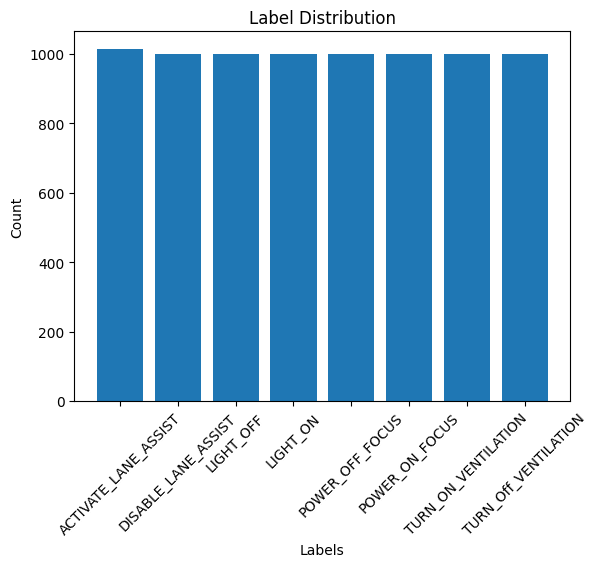

Epoch 1/50
101/101 [==============================] - 46s 397ms/step - loss: 1.1943 - accuracy: 0.5062 - val_loss: 0.6584 - val_accuracy: 0.7124
Epoch 2/50
101/101 [==============================] - 36s 354ms/step - loss: 0.5601 - accuracy: 0.7749 - val_loss: 0.4854 - val_accuracy: 0.7773
Epoch 3/50
101/101 [==============================] - 35s 349ms/step - loss: 0.4031 - accuracy: 0.8641 - val_loss: 0.2241 - val_accuracy: 0.9195
Epoch 4/50
101/101 [==============================] - 38s 377ms/step - loss: 0.2915 - accuracy: 0.9072 - val_loss: 0.1867 - val_accuracy: 0.9345
Epoch 5/50
101/101 [==============================] - 36s 352ms/step - loss: 0.2133 - accuracy: 0.9371 - val_loss: 0.1994 - val_accuracy: 0.9376
Epoch 6/50
101/101 [==============================] - 35s 349ms/step - loss: 0.1712 - accuracy: 0.9509 - val_loss: 0.1935 - val_accuracy: 0.9370
Epoch 7/50
101/101 [==============================] - 36s 353ms/step - loss: 0.1468 - accuracy: 0.9591 - val_loss: 0.1946 - val_ac

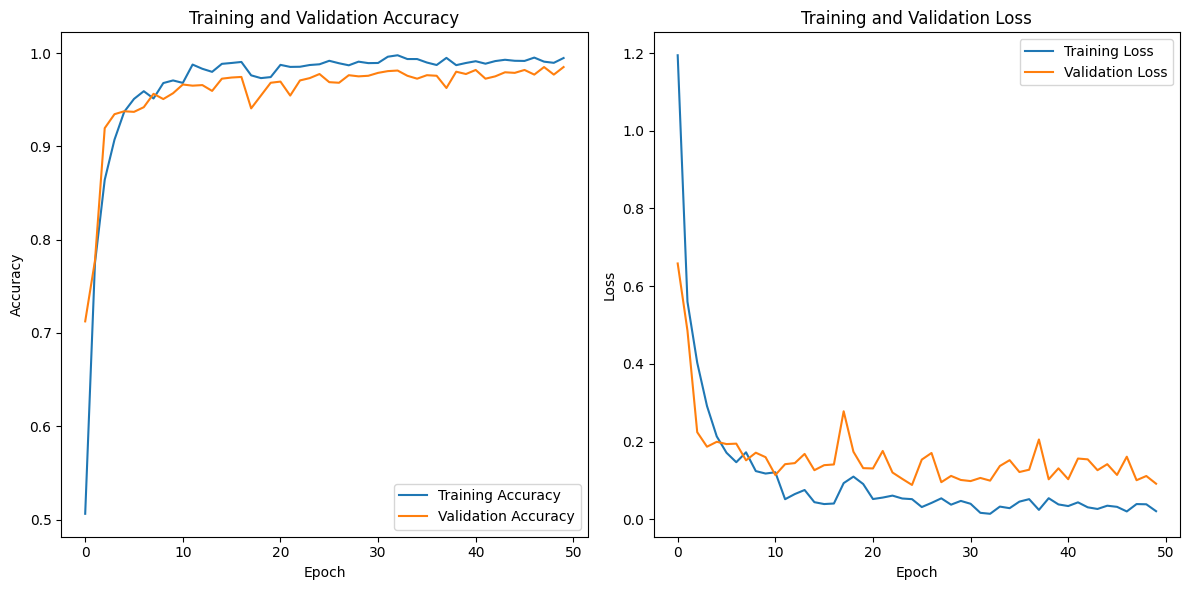

51/51 [==============================] - 4s 67ms/step


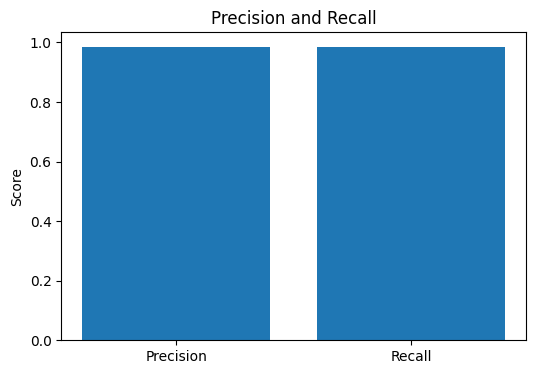

In [2]:
# Define the path to the directory containing your audio files
audio_dataset_path = "/content/drive/MyDrive/DATA/AUDIO"
# Define a fixed length for MFCCs
max_length = 100  # Adjust this value as needed

# Function to extract MFCC features from audio files and pad or truncate them to a fixed length
def extract_features(file_name, max_length=max_length):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

    # Pad or truncate the features to the fixed length
    if mfccs.shape[1] < max_length:
        # Pad the features with zeros
        mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        return mfccs_padded
    else:
        # Truncate the features
        return mfccs[:, :max_length]

# Initialize lists to store extracted features and labels
features_list = []
labels_list = []

# Iterate through each directory (class label)
for class_label in os.listdir(audio_dataset_path):
    # Construct the path to the current class label directory
    class_dir_path = os.path.join(audio_dataset_path, class_label)

    # Check if the current item in the directory is a directory itself
    if os.path.isdir(class_dir_path):
        # Iterate through each audio file in the class label directory
        for audio_file in os.listdir(class_dir_path):
            # Construct the file path
            file_name = os.path.join(class_dir_path, audio_file)
            # Extract features from the audio file and pad or truncate them
            features = extract_features(file_name)

            # Append the extracted features and label to the lists
            features_list.append(features)
            labels_list.append(class_label)

# Convert lists to NumPy arrays
X = np.array(features_list)
y = np.array(labels_list)

# Plot label distribution
unique_labels, label_counts = np.unique(y, return_counts=True)
plt.bar(unique_labels, label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()

# Reshape features for LSTM input (add time dimension)
X = np.expand_dims(X, axis=3)

# Convert class labels to one-hot encoded format
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the RNN-LSTM model
model = Sequential([
    LSTM(units=256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.5),
    LSTM(units=128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Visualize accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

# Additional Metrics Visualization (example using Precision and Recall)
from sklearn.metrics import precision_score, recall_score

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_test_labels, y_pred_classes, average='macro')
recall = recall_score(y_test_labels, y_pred_classes, average='macro')

# Plot additional metrics
plt.figure(figsize=(6, 4))
plt.bar(['Precision', 'Recall'], [precision, recall])
plt.ylabel('Score')
plt.title('Precision and Recall')
plt.show()



In [4]:
from sklearn.metrics import confusion_matrix

In [6]:
import seaborn as sns

In [8]:
from sklearn.metrics import classification_report

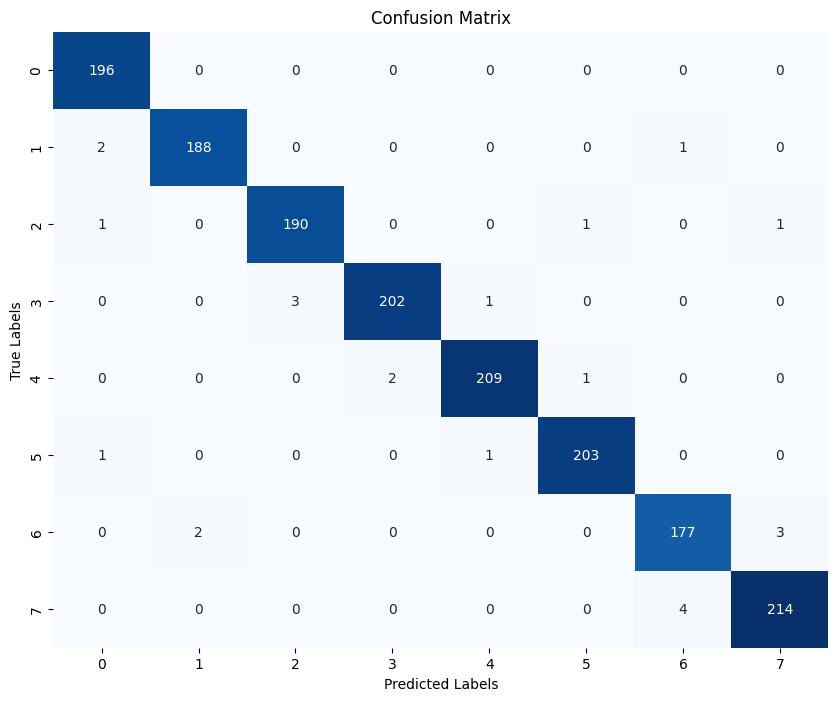

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       196
           1       0.99      0.98      0.99       191
           2       0.98      0.98      0.98       193
           3       0.99      0.98      0.99       206
           4       0.99      0.99      0.99       212
           5       0.99      0.99      0.99       205
           6       0.97      0.97      0.97       182
           7       0.98      0.98      0.98       218

    accuracy                           0.99      1603
   macro avg       0.98      0.98      0.98      1603
weighted avg       0.99      0.99      0.99      1603



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report
class_report = classification_report(y_test_labels, y_pred_classes)
print("Classification Report:")
print(class_report)

# Save the model
model.save('/content/drive/MyDrive/DATA/BEST_RNN_LSTM_model.h5')
